In [2]:
from core.utils.load_demands import load_demands_and_pv
import matplotlib.pyplot as plt
from enstats.clustering.clustering_optimizer.system_identification \
    .one_step_optimization import OneStepOptimizationFROLS
from ebcpy.data_types import TimeSeriesData as Tsd
import pandas as pd
import numpy as np
from pprint import pprint
from sampc.utils.multi_step_runner import calc_multi_step_error
from sampc.utils.utils import get_output_position_change
from enstats.preprocessing.utils import tsd_preparation_from_feature_list
from sklearn.metrics import mean_squared_error as mse
from core.machine_learning.heat_demand_forecast import HeatingDemandLearner
from sampc.utils.multi_step_runner import runner_segment_y

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
building_ix = 0
hd = HeatingDemandLearner(building_ix=building_ix)
hd.get_model()
print(building_ix)
pprint(hd.features)
print("")

0
[('heating_0//1', 'raw'), ('heating_0//2', 'raw'), ('sin//1', 'raw')]



In [4]:
data = hd.run_data[hd.features].copy()
data.reset_index(inplace=True, drop=True)
data = data.iloc[:hd.n_horizon].copy()
data.loc[1:, data.columns[0:2]] = np.nan
data


Variables,heating_0//1,heating_0//2,sin//1
Tags,raw,raw,raw
0,1805.91,1512.5,-0.965926
1,NaN,NaN,-0.866025
2,NaN,NaN,-0.707107
3,NaN,NaN,-0.500000
4,NaN,NaN,-0.258819
5,NaN,NaN,0.000000
6,NaN,NaN,0.258819
7,NaN,NaN,0.500000
8,NaN,NaN,0.707107


In [5]:

y_hat = hd.predict_n_steps(data)
y_hat
    

array([[1792.2700],
       [1875.9147],
       [1910.0894],
       [1941.3653],
       [1950.2393],
       [1941.8569],
       [1914.4735],
       [1870.4540],
       [1812.3157],
       [1743.8809],
       [1669.5548],
       [1594.1862]])

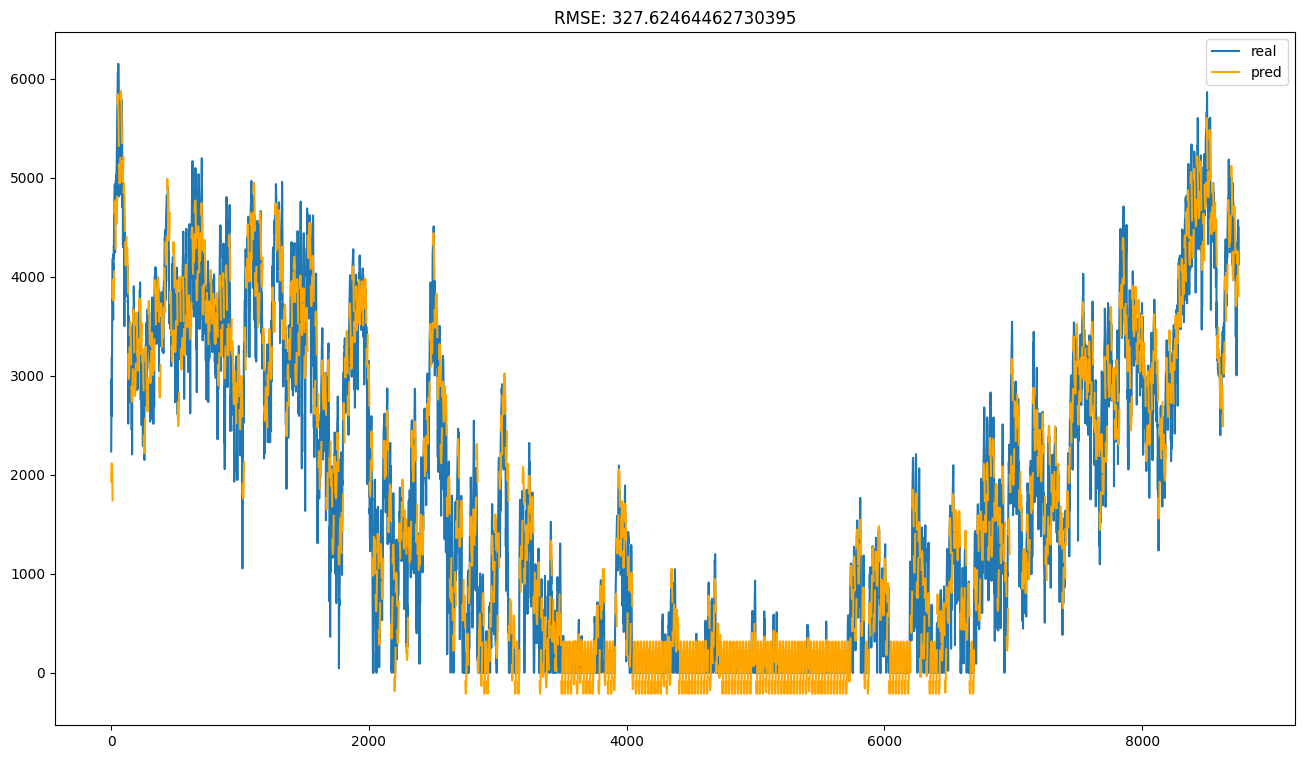

In [5]:
#hd.run_and_plot_single_step()
#print(hd.n_step_error)
hd.run_and_plot_multi_step()

In [8]:
data = load_demands_and_pv().iloc[::4].copy()
#tsd = Tsd(data)
new_cols = [f'{i[0]}_{i[1]}' for i in list(data)]
data_new = pd.DataFrame(columns=new_cols, data=data.to_numpy())
tsd = Tsd(data_new)

In [10]:
building_ix = 0
imp_cols = [i for i in list(tsd) if f'_{building_ix}' in i[0]]
use_data = data_new[imp_cols].copy()
    
use_data

hours = data.index.hour + data.index.minute / 60
print(hours[:80])
B = 2 * np.pi / 24
C = -np.pi / 2
use_data[('sin', 'raw')] = np.sin(B * hours + C)
use_data[('time', 'raw')] = data.index
use_data[('Class', 'constant')] = 0
use_data


Float64Index([ 0.0,  1.0,  2.0,  3.0,  4.0,  5.0,  6.0,  7.0,  8.0,  9.0, 10.0,
              11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0,
              22.0, 23.0,  0.0,  1.0,  2.0,  3.0,  4.0,  5.0,  6.0,  7.0,  8.0,
               9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0,
              20.0, 21.0, 22.0, 23.0,  0.0,  1.0,  2.0,  3.0,  4.0,  5.0,  6.0,
               7.0,  8.0,  9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0,
              18.0, 19.0, 20.0, 21.0, 22.0, 23.0,  0.0,  1.0,  2.0,  3.0,  4.0,
               5.0,  6.0,  7.0],
             dtype='float64')


Variables,cooling_0,dhw_0,elec_0,heating_0,pv_power_0,sin,time,Class
Tags,raw,raw,raw,raw,raw,raw,raw,constant
0,0.0,0.00,85.03,1512.50,0.0,-1.000000,2018-01-01 00:00:00,0
1,0.0,0.00,85.03,1805.91,0.0,-0.965926,2018-01-01 01:00:00,0
2,0.0,0.00,85.03,2083.02,0.0,-0.866025,2018-01-01 02:00:00,0
3,0.0,0.00,85.03,2345.05,0.0,-0.707107,2018-01-01 03:00:00,0
4,0.0,0.00,85.03,2567.81,0.0,-0.500000,2018-01-01 04:00:00,0
...,...,...,...,...,...,...,...,...
8755,0.0,0.00,278.31,4590.13,0.0,-0.258819,2018-12-31 19:00:00,0
8756,0.0,949.94,389.78,4618.73,0.0,-0.500000,2018-12-31 20:00:00,0
8757,0.0,1078.20,2077.50,4248.02,0.0,-0.707107,2018-12-31 21:00:00,0


In [20]:
output_variables = [('heating_0', 'raw')]
features = [i for i in list(use_data) if i not in output_variables]

features = [i for i in features if i[0] != 'time']
features = [('sin', 'raw'), ('ones', 'raw')]
use_data[('ones', 'raw')] = 1

opt = OneStepOptimizationFROLS(data=use_data,
                               output_variables=output_variables,
                               input_variables=features,
                               environment_variables=None,
                               class_column=('Class', 'constant'),
                               train_test=0.7,
                               scaling_method='minmax',
                               verbose=False,
                               compare_with_no_ode=False
                               )
opt.optimize()

{'coeffs': array([[0.6931, 0.3188, -45.3372, -45.3372]]),
 'error': 198.52051096230068,
 'error_metric': 'rmse',
 'features': [('heating_0//1', 'raw'),
              ('heating_0//2', 'raw'),
              ('sin//1', 'raw'),
              ('ones', 'raw')],
 'id': 'Down. Lag: 3',
 'n_points': 2627,
 'r2': 0.9827571257830514}


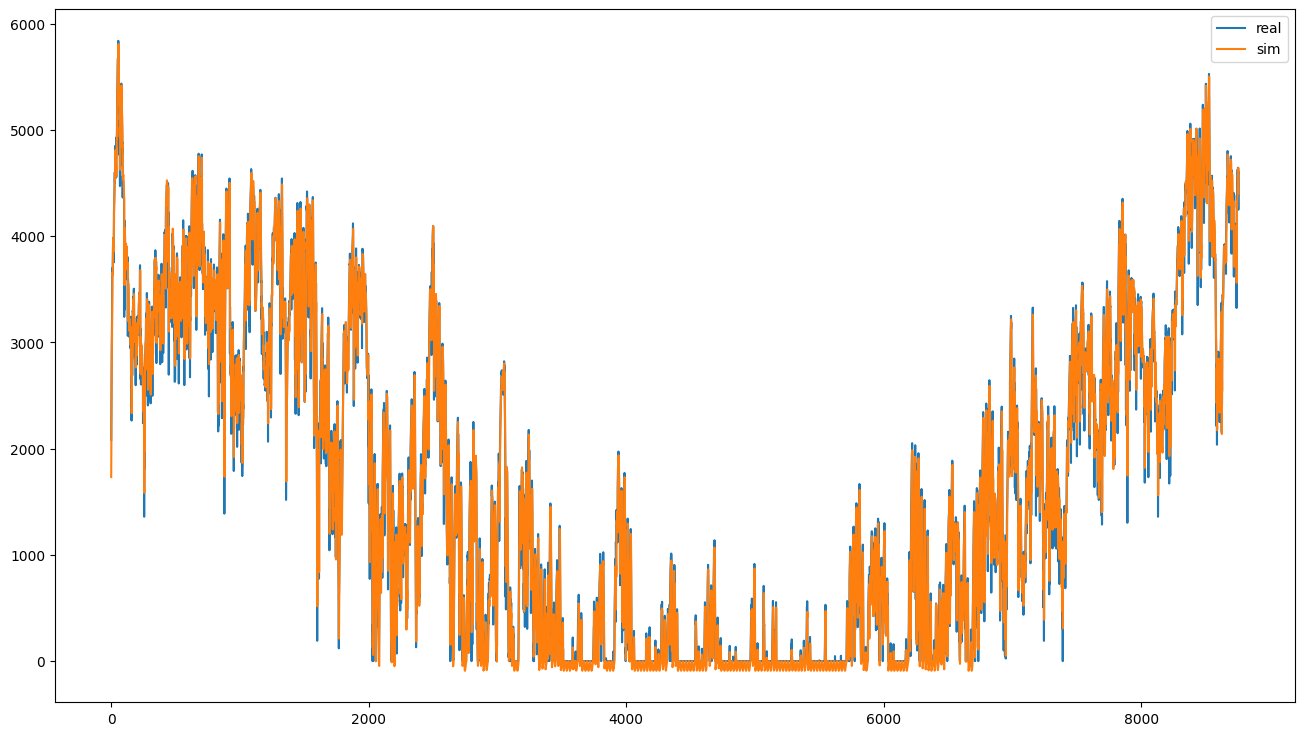

201.639953359298


In [21]:
res_dict = opt.best_results
inv_scaled_dict = opt.get_inverse_scaled_results()[0]['result']
inv_scaled_dict
pprint(inv_scaled_dict)
features = inv_scaled_dict['features']
coeffs = inv_scaled_dict['coeffs']

run_data = tsd_preparation_from_feature_list(use_data, features)


X = run_data[features].to_numpy()
y = run_data[output_variables].to_numpy()

y_pred = X @ coeffs.T

plt.figure(figsize=(16, 9))
plt.plot(y, label='real')
plt.plot(y_pred, label='sim')
plt.legend()
plt.show()

rmse = mse(y_pred, y) ** 0.5
print(rmse)

In [22]:
out_pos = get_output_position_change(feature_list=features,
                                     output_variables=output_variables)


In [23]:
n_horizon = 36
x_list = [X]
y_list = [y]

(error,
 _y_arrays,
 _y_pred_array) = calc_multi_step_error(x_list=x_list,
                              y_list=y_list,
                              out_is_dt=False,
                              scaling_dict=None,
                              coeffs=coeffs,
                              pos_change=out_pos,
                              n_horizon=n_horizon,
                              return_arrays=True)

In [24]:
print(error)
y_arrays = _y_arrays[0]
y_pred_arrays = _y_pred_array[0]
y_arrays

732.1067903421828


array([[2083.0200, 2345.0500, 2567.8100, ..., 4722.9600, 4623.2000,
        4592.0800],
       [2345.0500, 2567.8100, 2773.9700, ..., 4623.2000, 4592.0800,
        4662.7900],
       [2567.8100, 2773.9700, 2939.4600, ..., 4592.0800, 4662.7900,
        4692.3500],
       ...,
       [4039.3300, 3618.6500, 3861.1000, ..., 4642.8700, 4590.1300,
        4618.7300],
       [3618.6500, 3861.1000, 4066.7600, ..., 4590.1300, 4618.7300,
        4248.0200],
       [3861.1000, 4066.7600, 4008.6000, ..., 4618.7300, 4248.0200,
        4592.9300]])

In [25]:
y_arrays

array([[2083.0200, 2345.0500, 2567.8100, ..., 4722.9600, 4623.2000,
        4592.0800],
       [2345.0500, 2567.8100, 2773.9700, ..., 4623.2000, 4592.0800,
        4662.7900],
       [2567.8100, 2773.9700, 2939.4600, ..., 4592.0800, 4662.7900,
        4692.3500],
       ...,
       [4039.3300, 3618.6500, 3861.1000, ..., 4642.8700, 4590.1300,
        4618.7300],
       [3618.6500, 3861.1000, 4066.7600, ..., 4590.1300, 4618.7300,
        4248.0200],
       [3861.1000, 4066.7600, 4008.6000, ..., 4618.7300, 4248.0200,
        4592.9300]])

35
70
105
140
175
210
245
280
315
350
385
420
455
490
525
560
595
630
665
700
735
770
805
840
875
910
945
980
1015
1050
1085
1120
1155
1190
1225
1260
1295
1330
1365
1400
1435
1470
1505
1540
1575
1610
1645
1680
1715
1750
1785
1820
1855
1890
1925
1960
1995
2030
2065
2100
2135
2170
2205
2240
2275
2310
2345
2380
2415
2450
2485
2520
2555
2590
2625
2660
2695
2730
2765
2800
2835
2870
2905
2940
2975
3010
3045
3080
3115
3150
3185
3220
3255
3290
3325
3360
3395
3430
3465
3500
3535
3570
3605
3640
3675
3710
3745
3780
3815
3850
3885
3920
3955
3990
4025
4060
4095
4130
4165
4200
4235
4270
4305
4340
4375
4410
4445
4480
4515
4550
4585
4620
4655
4690
4725
4760
4795
4830
4865
4900
4935
4970
5005
5040
5075
5110
5145
5180
5215
5250
5285
5320
5355
5390
5425
5460
5495
5530
5565
5600
5635
5670
5705
5740
5775
5810
5845
5880
5915
5950
5985
6020
6055
6090
6125
6160
6195
6230
6265
6300
6335
6370
6405
6440
6475
6510
6545
6580
6615
6650
6685
6720
6755
6790
6825
6860
6895
6930
6965
7000
7035
7070
7105
7140
7175
7210


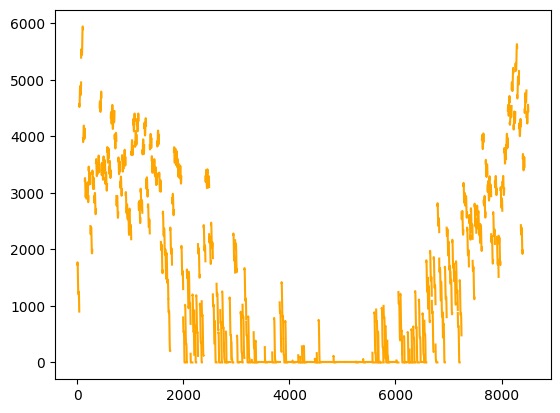

In [42]:
y_pred_all = y_pred_arrays[::n_horizon]
ix_start = 0
for n in y_pred_all:
    x = np.arange(start=ix_start, stop=ix_start + n.shape[0])
    

    ix_start = x[-1]
    
    print(ix_start)    
    plt.plot(x, n, c='orange')
    

plt.show()

(243, 36)


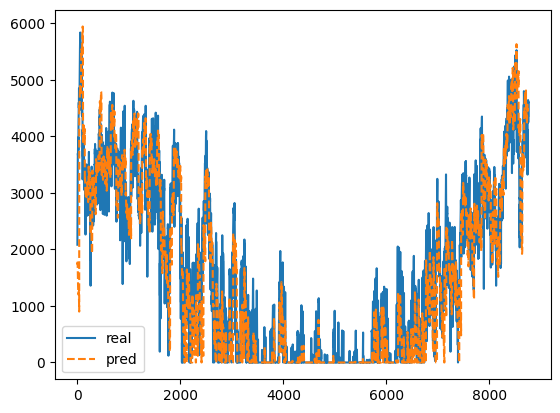

607.574993558952


In [27]:
y_pred_all = y_pred_arrays[::n_horizon]
print(y_pred_all.shape)
n_points = y_pred_all.shape[0] * y_pred_all.shape[1]
y_pred_all = y_pred_all.reshape(1, n_points).flatten()

start = 0
stop = 10000
y_pred_all[y_pred_all < 0] = 0
plt.plot(y[start:stop], label='real')
plt.plot(y_pred_all[start:stop], label='pred', linestyle='--')
plt.legend()
plt.show()

print(mse(y_pred_all, y[:y_pred_all.shape[0]]) ** 0.5)

In [38]:
a = np.array([[1, 2],
              [3, 4]])

a.reshape(1, 4)

array([[1, 2, 3, 4]])

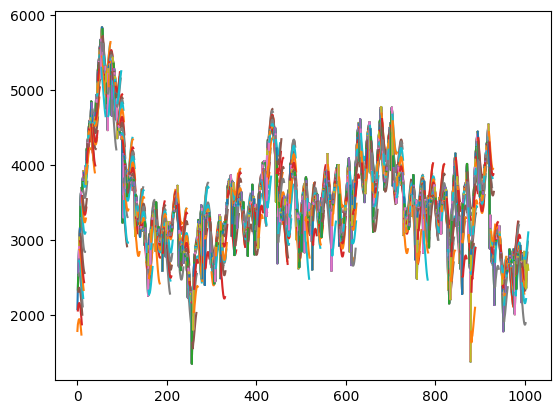

In [30]:
for n in range(1000):
    _y = y_arrays[n]
    _y_pred = y_pred_arrays[n]
    
    x = np.arange(start=n, stop=n+_y.shape[0])
    
    plt.plot(x, _y)
    plt.plot(x, _y_pred)
    
plt.show()